In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from graphstats import *
import copy
from tqdm import tqdm_notebook as tqdm

The goal of the current notebook is to extend the ideas in my thesis to an unsupervised (i.e. clustering) setting. In particular we must build a similarity metric for the edge weights into the objective function that governs the agglormerative/herarchical clustering.


The natural application is in a likelihood based clustering procedure where we update the priors associated with each cluster using some extra-clustering space information (in a basic case this information is conditionally independent edge weights).

To demonstrate the effectiveness and applicability of this method we use an SBM structure that implies uni-variate covariates and simply implement K-Means.

Things to investigate:

1) ARI(weighted_hclust) - ARI(unweighted_hclust) vs mu1 - mu2

2) ARI(weighted_hclust) - ARI(gmm) vs mu1 - mu2

3) ARI(weighted EM) - ARI(gmm) vs mu1 - mu2

4) Non-par weight methods ?

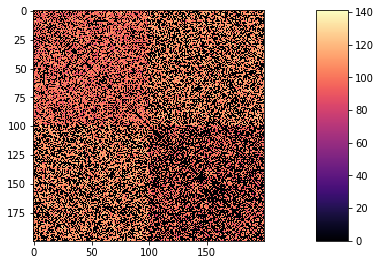

In [2]:
n = 200
seed_ratio = 0.1

# Class 1 prior
pi1 = 0.5

# Class 2 prior
pi2 = 1 - pi1
pis = np.array([pi1, pi2])
pi = pis

# Setting up B matrix
p = 0.8
q = 0.65

B = np.array([[p**2, p*q], [p*q, q**2]])

# Hard coding the maximum embedding dimension
max_dim = 1

# Setting the edge weight distribution parameters
mu1 = 100
mu2 = 110
scale1 = 9
scale2 = 9
means = np.array([[mu1, mu2], [mu2, mu1]])
scales = np.array([[scale1, scale2], [scale2, scale1]])

C = adj_matrix(n, pi, B, True, dist = 'normal', means = means, scales = scales, acorn = 2)
plt.imshow(C, cmap=plt.get_cmap('magma'))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

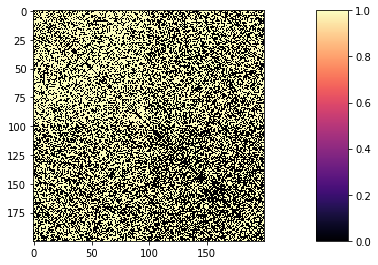

In [3]:
A = strip_weights(C)
plt.imshow(A, cmap=plt.get_cmap('magma'))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

(-0.01, 0.2)

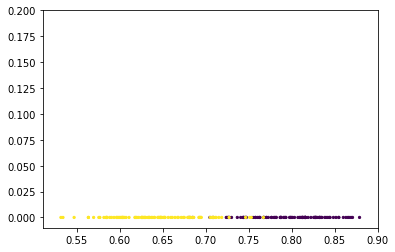

In [4]:
A = strip_weights(C)
X_hat = adj_spectral_embedding(A, max_dim = 1)[0]
fig, ax = plt.subplots(1,1)
zeros = np.zeros(int(pi1*n))
ones = np.ones(int((1 - pi1)*n))

ax.scatter(X_hat, np.zeros(len(X_hat)), c = np.concatenate((zeros, ones)), s = 5)
ax.set_ylim(-0.01, 0.2)

In [13]:
def weighted_hclust1d(
    X, 
    W, 
    labels = [], 
    use_weights = True, 
    x_likelihoods = None, 
    w_likelihoods = None
    return_likelihoods = False):
    
    # To simplify the implementation, we assume we are working in one dimension.
    # Moreover, we assume that edge weights are distributed normally with variance equal to 1
    
    # X - Vectors in R^d
    # W - A weight matrix (or in a zero-inflated case, the weighted adjacency matrix)
    # indices - A list of lists of indicies, i.e. indices[0] = [ind(object i in cluster 0) for i in N]
    # K - number of clusters
    # labels - a list of labels
    
    # Store the number of nodes
    N = W.shape[0]
    
    # Store the unique labels and associated counts
    unique_labels, label_counts = np.unique(labels, return_counts = True)
    
    # Store the number of unique labels
    current_K = len(unique_labels)
    
    print("Going from %i to %i clusters!"%(current_K, current_K - 1))

    # Return a vector of zeros (indicating all nodes are in the same class)
    # if there are at most two unique labels
    if current_K <= 2:
        print("returning because K <= 2")
        return np.zeros(N)
    
    # Give indices to each node
    all_idx = np.arange(N)
    
    # Store indices associated with each unique label
    cluster_idx = [all_idx[labels == i] for i in unique_labels]
    
    # Store Euclidian means associated with each unique label
    eucl_means = np.array([np.mean(X[i]) for i in cluster_idx])
    
    # The associated variances are trickier to calculate, since the
    # magnitude of the variance affects the combination of early clusters
    # immensely. The way that i get around this is to give each cluster the same
    # variance until all clusters have at least two nodes in it.
    if min(label_counts) == 1:
        eucl_scales = np.array([np.std(X, ddof = 1) for i in unique_labels])
    else:
        eucl_scales = np.array([np.std(X[i], ddof = 1) for i in cluster_idx])
        
    # Initialize the likelihoods for each cluster
    
    if x_likelihoods is None:
        x_likelihoods = np.zeros(current_K)

        # Find the likelihoods associated with each cluster. Unsure if this is necessary.
        for k in range(current_K):
            temp_idx = cluster_idx[k]
            temp_n = len(temp_idx)
            temp_mean = eucl_means[k]
            temp_scale = eucl_scales[k]
            temp_likelihoods = np.log([norm.pdf(X[i], temp_mean, temp_scale) for i in temp_idx])
            x_likelihoods[k] += np.sum(temp_likelihoods)
        
    # Store the weights associated with each cluster in a list of lists.
    weights = get_weights(W, all_idx, labels)
    
    # Find the number of weights associated with each cluster to every other cluster
    # weight_lenghts \in \mathcal{M}_{K} = \mathbb{R}^{K x K}
    weight_lengths = np.array([[len(weights[i][j]) for j in range(current_K)] for i in range(current_K)])
    
    # We can only utilize the weights in a meaningful sense if all of the weight lengths are
    # greater than one. 
    if np.sum(weight_lengths[weight_lengths > 1]) < current_K**2 or not use_weights:
        
        # We need to initialize the maximums so that we can optimize over
        # the combinations of cluster indices. To do this, we first combine
        # the first two clusters by index.
        idx12 = np.concatenate((cluster_idx[0], cluster_idx[1]))
        
        # Store the associated Euclidian mean
        mean12 = np.mean(X[idx12])

        # Only estimate variances if the smallest cluster has more than 2 members.
        if min(label_counts) == 1:
            std12 = eucl_scales[0]
        else:
            std12 = np.std(X[idx12], ddof = 1)
            
        # Find the likelihood associated with the combined cluster.
        likelihood12 = np.sum(np.log([norm.pdf(X[i], mean12, std12) for i in idx12]))

        # Store the likelihood associated with the model in which the first
        # 2 clusters are combined as the max value
        max_likelihood = likelihood12 + np.sum(np.log(x_likelihoods[2:]))
        
        # Store the indices associated with the maximally likely model.
        max_idx = [0, 1]
        
        # Now, optimize over pairs of clusters
        for i in range(len(unique_labels)):
            for j in range(i + 1, len(unique_labels)):
                # Combine node indices associated with each cluster
                temp_idx = np.concatenate((cluster_idx[i], cluster_idx[j]))
                
                # Store the Euclidian mean associated with the combined cluster
                temp_mean = np.mean(X[temp_idx])
                
                # Only estimate variances if the smallest cluster has more than 2 members.
                if min(label_counts) == 1:
                    temp_std = eucl_scales[0]
                else:
                    temp_std = np.std(X[temp_idx], ddof = 1)
                    
                # Calculate the likelihood associated with the new cluster
                temp_likelihood = np.sum(np.log([norm.pdf(X[k], temp_mean, temp_std) for k in temp_idx]))
                temp_model_likelihood = temp_likelihood + np.sum(np.log(x_likelihoods[:i]))
                temp_model_likelihood += np.sum(np.log(x_likelihoods[i + 1: j])) + np.sum(np.log(x_likelihoods[j + 1:]))

                if temp_model_likelihood > max_likelihood:
                    max_likelihood = temp_model_likelihood
                    max_idx = [i, j]
                    max_cluster_labels = i*np.ones(len(temp_idx))
        
    else:
        # can use weights!
        idx12 = np.concatenate((cluster_idx[0], cluster_idx[1]))
        mean12 = np.mean(X[idx12])
    
        if min(label_counts) == 1:
            std12 = eucl_scales[0]
        else:
            std12 = np.std(X[idx12], ddof = 1)
            
        # Euclidian likelihood
        likelihood12 = np.sum(np.log([norm.pdf(X[i], mean12, std12) for i in idx12]))
        max_likelihood = likelihood12 + np.sum(np.log(x_likelihoods[2:]))
        
        # Initialize the indices corresponding to the maximally likely cluster combination
        max_idx = [0, 1]
        
        # Combine weights for class 0 and class 1
        max_weights = combine_weights(0, 1, weights)
        next_K = len(max_weights)
        
        # Initalize the likelihood
        total_weight_likelihood = 1

        # Find the likelihood when 0 and 1 are combined (max_weights)
        if w_likelihood is None:
            for i in range(next_K): # For each cluster..
                for j in range(next_K): # For every other cluster (including itself)
                    # Find likelihood of the weights
                    temp_mean = np.mean(max_weights[i][j])
                    temp_std = np.std(max_weights[i][j], ddof = 1)                    
                    temp_wl = np.sum(np.log([norm.pdf(k, temp_mean, temp_std) for k in max_weights[i][j]]))
                    total_weight_likelihood += temp_wl
        
        # weight likelihood times Euclidian likelihood
        total_likelihood = total_weight_likelihood + likelihood12
        
        # Initialize max likelihood
        max_likelihood = total_likelihood
                
        for i in range(current_K): # For every cluster..
            for j in range(i + 1, current_K): # For every unique pairing of indices (not including (i, i) pairs)
                # Find the weight likelihood * Euclidian likelihood
                
                # Store the indices of the data for the clusters to combine
                temp_idx = np.concatenate((cluster_idx[i], cluster_idx[j]))
                
                # Find the Euclidian mean corresponding to the combined clusters
                temp_mean = np.mean(X[temp_idx])
                
                # If at least one of the clusters only has one point in it then clusters with more than one point
                # are more likely to continue to expand unless the default variance for singleton clusters is large
                # enough
                
                if min(label_counts) == 1:
                    temp_std = eucl_scales[0]
                else:
                    temp_std = np.std(X[temp_idx], ddof = 1)
                    
                # Calculate likelihood for the data in the newly combined cluster
                temp_likelihood = np.sum(np.log([norm.pdf(X[k], temp_mean, temp_std) for k in temp_idx]))
                
                # There are four pieces needed to calculate the model likelihood..
                # The likelihood of the clusters up to but not including cluster i
                # The likelihood of the newly joined cluster
                # The likelihood of the clusters between i and j 
                # The likelihood of the clusters after j

                temp_model_likelihood = temp_likelihood + np.sum(np.log(x_likelihoods[:i]))
                temp_model_likelihood += np.sum(np.log(x_likelihoods[i + 1: j])) + np.sum(np.log(x_likelihoods[j + 1:]))
                    
                # Now the part of the likelihood corresponding to the edge weights
                
                # Combine the edge weights corresponding to blocks i and j
                new_weights = combine_weights(i, j, weights)
                
                # Initialize edge weight likelihood
                total_weight_likelihood = 0
                
                for p in range(next_K): # For each cluster
                    for q in range(next_K): # For every other cluster
                        # Find the likelihood of the edge weights being in the current configuration
                        temp_mean = np.mean(new_weights[p][q])
                        temp_std = np.std(new_weights[p][q], ddof = 1)
                        temp_wl = np.sum(np.log([norm.pdf(k, temp_mean, temp_std) for k in new_weights[p][q]]))
                        total_weight_likelihood += temp_wl
        
                # Calculate total model likelihood
                total_likelihood = total_weight_likelihood + temp_model_likelihood
                            
                # Update variables corresponding to the maximum if needed
                if total_likelihood > max_likelihood:
                    print(i, j, total_likelihood)
                    max_likelihood = total_likelihood
                    max_idx = [i, j]
                    max_cluster_labels = i*np.ones(len(temp_idx))

    new_labels = labels.copy()
    new_labels[cluster_idx[max_idx[1]]] = unique_labels[max_idx[0]]
    print(unique_labels[max_idx[0]], unique_labels[max_idx[1]])
    
    if return_likelihoods:
        return new_labels, x_likelihoods, w_likelihoods
    else:
        return new_labels

In [14]:
def combine_weights(i, j, list_of_weight_lists):
    K = len(list_of_weight_lists)
    
    new_list = copy.deepcopy(list_of_weight_lists)
    for k in range(K):
        temp_i = new_list[k][i]
        temp_j = new_list[k][j]
        new_list[k][i] = np.concatenate((temp_i, temp_j))
        
#         if k != i and k != j:
        del new_list[k][j]
        
    del new_list[j]
    return new_list.copy()

In [15]:
import _pickle as pickle
X_hat = pickle.load(open('X_hat.pkl', 'rb'))
labels = pickle.load(open('labels.pkl', 'rb'))
C = pickle.load(open('weighted_adjmat.pkl', 'rb'))

In [16]:
test = labels
unique_labels = np.unique(labels)
N = len(unique_labels)
for i in range(N - 1):
    test = weighted_hclust1d(X_hat, C, test, use_weights=True)
    print(test)

Going from 18 to 17 clusters!
0 1 -65431.818543945046
0 3 -64953.303539189685
0 6 -64778.86383781453
1 6 -64769.4064408176
2 6 -64701.956476931184
4 6 -64595.86546171042
23 53
[  0   0   0   0   0   0   0   0   0   0  10   0  12   0  10   0  16   0
   0  10   0   0   0  23  24   0   0   0   0   0   0  12   0  16   0   0
  24  24   0   0   0  16   0   0   0  10   0   0   0   0   0  12  10  23
   0  16  24  24   0   0   0  16   0   0  16   0   0  12   0   0   0  12
   0   0   0   0  10  16   0   0  12   0  23   0   0   0  23   0   0  16
   0   0   0   0  10   0  16  24   0   0 100 101 102 103 104 102 106 101
 106 100  23 111 112 113 112  23 103 102 104 101 120 103  23   0 124   0
  23 113 111 113  23 113 112 106  23 103 124   0 104  23 120 124  23 100
 112 104 111 112 111 112 100 111 103 111 124 106 124 113 102 106 112 101
  23 101 124 106 102 103  23  12 124 101 101 112 124 113 100 106 103 104
  23 120 103 104  23  23  23 112  23 103  23 104 103 103  24  23 101 124
 103 102]
Going from 

0 1 -51621.50006276398
0 2 -51533.44969792332
0 5 -50818.87851145427
0 112
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 102   0 104 102 106   0
 106   0   0 111   0 113   0   0   0 102 104   0 120   0   0   0 124   0
   0 113 111 113   0 113   0 106   0   0 124   0 104   0 120 124   0   0
   0 104 111   0 111   0   0 111   0 111 124 106 124 113 102 106   0   0
   0   0 124 106 102   0   0   0 124   0   0   0 124 113   0 106   0 104
   0 120   0 104   0   0   0   0   0   0   0 104   0   0   0   0   0 124
   0 102]
Going from 8 to 7 clusters!
0 1 -49371.57127355591
0 2 -49281.018622417
0 7 -48655.28556853317
0 124
[  0   0   

(-0.01, 0.2)

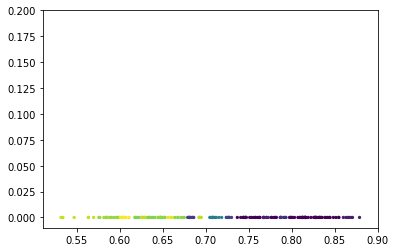

In [8]:
fig, ax = plt.subplots(1,1)

ax.scatter(X_hat, np.zeros(len(X_hat)), c = labels, s = 5)
ax.set_ylim(-0.01, 0.2)